# **Rèplica primera sessió - càrrega de dades**

## Experimentació càrrega de dades

In [ ]:
# Atajos útils:
# Ctrl + / --> comentar (en el numeric pad!)
# Ctrl + ç --> comentar tb

Primerament instal·lem un parell de ferramentes útils

In [ ]:
pip install -r requirements.txt
pip install lckr-jupyterlab-variableinspector

Repliquem el mecanisme de càlcul de temps d'execució

In [ ]:
# Examen d'eficiència
startTime = time.time()
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\all_train.csv")
endTime = time.time()
print(endTime-startTime)

# Tarda 63 segons! La meitat que el segon mecanisme en R.

In [ ]:
# f1000a = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug17.txt", mode ='r')
# f1000b = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt", mode ='r')
# readme = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt")
# lineslist = readme.readlines()
# cols, rows = (int(val) for val in lines_list[0].split())

In [ ]:
# Seleccionem únicament les dades signal/background
milTrSignal = alltr.loc[(alltr["mass"] == 1000) & (alltr["# label"] == 1)]
milTrBackground = alltr.loc[(alltr["mass"] == 1000) & (alltr["# label"] == 0)]
# adult_names = titanic.loc[titanic["Age"] > 35, "Name"]

# Error detectat: & té major prioritat que ==, així que cal emprar parèntesis!

In [ ]:
del(allTrBackground, allTrSignal) # Mètode per eliminar variables

## Càrrega de dades final

In [ ]:
# Cel·la definitiva - càrrega de dades
import pandas as pd
import numpy as np
import time

alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\all_train.csv")
miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\1000_train.csv")

In [ ]:
# Trunquem les dades, seleccionem únicament 10 000. A més, la separem en la informació coneguda i la que pretenem predir.
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[1:10001]
Xdata = Xdata[0:10000,:]

In [ ]:
print(Xdata)

In [ ]:
print(miltr)

# **Segona sessió: normalització, matrius de correlació i decision trees**

## Càrrega de dades (tr i tst)

In [2]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# del(alltr,alltst)
# del(miltr, miltst)

# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
Audio(sound_file, autoplay=True)

## Matrius de correlació

Preprocesem les dades: seleccionem solament signal (`# label == 1`) i variables HL i pTs

In [ ]:
milTrSignal = miltr.loc[miltr.index == 1]
milTrSignal = miltr.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

milTrBack = miltr.loc[miltr.index == 0]
milTrBack = miltr.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrBack.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

allTrSignal = alltr.loc[alltr["# label"] == 1]
allTrSignal = alltr.iloc[:,[1,7,11,15,19,23,24,25,26,27,28]]
allTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

Tr500Signal = allTrSignal.loc[allTrSignal["mass"] <= 500]
Tr750Signal = allTrSignal.loc[allTrSignal["mass"] == 750]
Tr1000Signal = allTrSignal.loc[allTrSignal["mass"] == 1000]
Tr1250Signal = allTrSignal.loc[allTrSignal["mass"] == 1250]
Tr1500Signal = allTrSignal.loc[allTrSignal["mass"] == 1500]

In [ ]:
print(Tr500Signal)

Representem la matriu

In [ ]:
import matplotlib.pyplot as plt

dataframe = Tr750Signal
dataframe = dataframe.iloc[:,0:10]

# plt.matshow(milTrSignal.corr())
# plt.show()
f = plt.figure(figsize=(10, 10))
plt.matshow(dataframe.corr(), fignum=f.number)

plt.xticks(range(dataframe.select_dtypes(['number']).shape[1]), dataframe.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dataframe.select_dtypes(['number']).shape[1]), dataframe.select_dtypes(['number']).columns, fontsize=14)

# ax=plt.gca() #get the current axes
# PCM=ax.get_children()[2]
# cb = plt.colorbar(PCM,ax=ax)
# cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix', fontsize=16);

In [ ]:
corr = dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
print(dataframe)

## Decision Trees

### Repliquem decision trees

Estudiem una mica algunes de les funcions que emprarem (`array` [bàsic de numpy], `bincount`, `arange`, `argwhere`, `flatten`)

In [ ]:
# bincount diguem-ne que fa un histograma de l'array
y = np.array([1,2,3,1,2])
np.bincount(y)

In [ ]:
# np.argwhere(condition) troba els elements que compleixen la condició
# .flatten ho transforma en vector, en comptes de llista de llistes
x = np.arange(5)
np.argwhere(x<3).flatten()

In [ ]:
# Algoritme per a Decision Trees basat en https://www.youtube.com/watch?v=NxEHSAfFlK8&list=PLcWfeUsAys2k_xub3mHks85sBHZvg24Jd&index=5
# Un parell d'ajusts, en la línia 94, afegisc un pas addicional per compatibilitzar bincounts amb les dades (float). No estic segur de si és adequat.


# L'asterisc força a passar value explícitament quan es cree un node: Node(value = blabla)
import numpy as np
from collections import Counter

class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None # Si existeix un valor, aleshores hi ha al menys un fill, per tant no és --> false
        

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        
        # Check the stopping criteria
        if (depth>=self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        # Si tenim el màxim de profunditat, si tenim un node pur o arribem al mínim de mostres, no crearem més
        
        feat_idx = np.random.choice(n_feats, self.n_features, replace = False)
        
        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idx) # Lloc on incloem la part aleatòria dels DT
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs,:],y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:],y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for thr in thresholds:
                # Calculate Information gain
                gain = self._information_gain(y, X_column, thr)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        
        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
           return 0
        
        # Calculate weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]),self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r    
           
        # Calculate IG
        information_gain = parent_entropy - child_entropy
        return information_gain
        
    def _entropy(self, y):
        uniq, inverse = np.unique(y, return_inverse=True) # Afegit per mi per poder fer el mateix amb floats en comptes d'int
        hist = np.bincount(inverse)
        ps = hist / len(y)
        return -np.sum([p*np.log(p) for p in ps if p > 0])
   
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
        
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] # Mirar en Logistic Regression
        return value
                        

    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
           return node.value
           
        if x[node.feature] <= node.threshold:
           return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



Emprem aquest DT *artesanal* amb els datasets proposats al vídeo.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

# from DecisionTree import DecisionTree

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 1234
)

clf = DecisionTree()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
    
acc = accuracy(y_test, predictions)
print(acc)

# Jugar amb més max_depth, diferents paràmetres

In [ ]:
print(Xdata)

Intentem emprar aquest DT amb els nostres datasets. Seleccionem les columnes LL per a Xdata i els índexs per al Ydata

In [ ]:
# Prova 1: trunquem les dades, seleccionem únicamen 10 000
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[1:10001]
Xdata = Xdata[0:10000,:]

In [ ]:
# Prova 2: no fem split en test i train,  
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[0:50000]
Xdata = Xdata[0:50000,:]

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

startTime = time.time()

X, y = Xdata, Ydata

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1, random_state = 1234
)

clf = DecisionTree(min_samples_split = 500, max_depth=4)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
    
acc = accuracy(y_test, predictions)
print(acc)

endTime = time.time()
print(endTime-startTime)

# Prova 1 amb 10.000 dades, None, None --> precisió de 1.0, temps d'execució ~ 15 minuts
# Prova 2 amb 100.000 dades, min_samples_split = 500, max_depth=4 --> precisió de ; temps d'execució > 4 hores, descartat

In [ ]:
print(clf.fit)

### Ferramentes sklearn

Una vegada hem replicat el codi bàsic d'un DT i hem interioritzat el procediment, emprem la llibreria sklearn, amb algoritmes més
testats i optimitzats, entenc.
El mètode anterior és ilustratiu, però inviable en termes de temps d'execució.

In [ ]:
# Prova 3: amb tots els esdeveniments
Ydata = np.array(miltr.index)
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(Xdata, Ydata)

# tree.plot_tree(clf)

endTime = time.time()
print(endTime-startTime) 

# Prova 2: 13 segons!?!?!
# Prova 3 (tots els esdeveniments, max_depth = 5): 174 segons?


# El plot del tree és un infern quan té massa depth, obviar.

In [ ]:
tree.plot_tree(clf)

Carreguem ara també les dades test per avaluar el Tree

In [ ]:
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\1000_test.csv")

In [ ]:
Ytst = np.array(miltst.iloc[:,0])
Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20"]])

In [ ]:
# print(miltst)
# print(Xtst)
# print(Ytst)

`score` sembla que calcula la precisió mitjana (https://github.com/scikit-learn/scikit-learn/blob/093e0cf14/sklearn/base.py#L680) 

In [ ]:
acc = clf.score(Xtst, Ytst)
print(acc)

Ara, unifiquem totes les parts de l'avaluació:

0. Càrrega de dades
1. Preparació de les dades i selecció de variables
2. Càlcul del DT
3. Avaluació del DT

In [ ]:
Ydata = np.array(alltr.iloc[:,[0]])

print(Ydata)

In [ ]:
print(alltr)

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = np.array(alltr.iloc[:,[0]])
Ytst = np.array(alltst.iloc[:,0])


# a) LL 
# Xdata = np.array(miltr.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20"]])
# Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12"
#                               ,"f13","f14","f15","f16","f17","f18","f19","f20"]])

# b) LL + HL 
# Xdata = np.array(miltr.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25"]])
# Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25"]])

# c) Selecció 1: f6 + HL
# Xdata = np.array(miltr.iloc[:,["f6","f21","f22","f23","f24","f25"]])
# Xtst = np.array(miltst.iloc[:,["f6","f21","f22","f23","f24","f25"]])

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])


# e) Alltr: d + mass
# Xdata = np.array(alltr.iloc[:,[1,4,7,27,28]])
# Xtst = np.array(alltst.iloc[:,[1,4,7,27,28]])

# f) Alltr: LL 
# Xdata = np.array(alltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Xtst = np.array(alltst.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12"
#                               ,"f13","f14","f15","f16","f17","f18","f19","f20","f21"]])

# g) Alltr: LL + HL 
# Xdata = np.array(alltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26","mass"]])

# h) Alltr: 3 5 6 26 27
# Xdata = np.array(alltr.iloc[:,[3,5,6,26,27]])
# Xtst = np.array(alltst.iloc[:,[3,5,6,26,27]])

# i) Alltr: 0 26 27
Xdata = np.array(alltr.loc[:,["f0","f26","mass"]])
Xtst = np.array(alltst.loc[:,["f0","f26","mass"]])



# Part 2: Càlcul DT
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(Xdata, Ydata)

temps = time.time() - startTime

print(temps)


# Part 3: Avaluació DT
acc = clf.score(Xtst, Ytst)
print(acc)

### Precisions 

- miltr LL, max_depth = 5, miltst:         0.54265

- miltr LL+HL, max_depth = 5, miltst:      0.68485 (temps = 202 s)
- miltr LL+HL, max_depth = 8, miltst:      0.65410 (temps = 350 s)
- miltr LL+HL, max_depth = 4, miltst:      0.72376 (temps = 157 s)
- miltr LL+HL, max_depth = 3, miltst:      0.74780 (temps = 115 s) !!
- miltr LL+HL, max_depth = 2, miltst:      0.57717 (temps =  75 s)

- miltr selecció 1, max_depth = 2, miltst: 0.66136 (temps = 20 s)
- miltr selecció 1, max_depth = 3, miltst: 0.66163 (temps = 29 s)
- miltr selecció 1, max_depth = 4, miltst: 0.66231 (temps = 39 s)

- miltr selecció 2, max_depth = 3, miltst: 0.90009 (temps = 21 s) !! Seleccione aquestes variables pq són les que empra en t = 115 
- miltr selecció 2, max_depth = 4, miltst: 0.90504 (temps = 28 s)
- miltr selecció 2, max_depth = 2, miltst: 0.89052 (temps = 14 s)
- miltr selecció 2, max_depth = 5, miltst: 0.90687 (temps = 36 s)
- miltr selecció 2, max_depth = 6, miltst: 0.90724 (temps = 43 s)


- alltr d + mass, max_depth = 3, alltst:   0.80764 (temps = 22 s)
- alltr d + mass, max_depth = 4, alltst:   0.82198 (temps = 31 s)
- alltr d + mass, max_depth = 2, alltst:   0.80764 (temps = 22 s)
- alltr d + mass, max_depth = 5, alltst:   0.83335 (temps = 35 s)

- alltr LL, max_depth = 8, alltst:         0.81532 (temps = 288 s)
- alltr LL + HL, max_depth = 8, alltst:    0.84975 (temps = 360 s)
- alltr h, max_depth = 2, alltst:          0.76904 (temps =  16 s)
- alltr h, max_depth = 4, alltst:          0.77089 (temps =  31 s)
- alltr i, max_depth = 4, alltst:          0.79936 (temps =  17 s)

Per calcular l'error de les precisions, potser es podria plantejar dividir la mostra de test i després fer la desviació de la precisió? Quin rigor tindria?

In [ ]:
tree.plot_tree(clf)

In [ ]:
# print(Xdata)
# print(Ydata)
# print(Xtst)
# print(miltr)
# print(miltst)

# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])

### Càlcul i avaluació completa amb accuracy + kappa + F1-score

In [ ]:
import math
# Comprovació del mecanisme per a calcular
# temp = np.array(alltr.loc[:,["f25","f26"]])
# temp[:,0] = temp[:,0]/temp[:,1]

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = np.array(alltr.iloc[:,[0]])
Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
# label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# k) Alltr: HL + # label  --> Solament selecciona el mateix que j, almenys fins a depth = 5
# Xdata = np.array(alltr.loc[:,["f0","f22","f23","f24","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f22","f23","f24","f25","f26","mass"]])
# label = "k"

# l) Altres variables? Masses invariants pseudonormalitzades?
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# Xdata[:,2] = Xdata[:,2] / Xdata[:,3]
# Xdata[:,1] = Xdata[:,1] / Xdata[:,3]
# Xtst[:,2] = Xtst[:,2] / Xtst[:,3]
# Xtst[:,1] = Xtst[:,1] / Xtst[:,3]
# label = "l"

# m) Altres variables? Masses invariants pseudonormalitzades?
Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
Xdata[:,2] = Xdata[:,2] / np.log(Xdata[:,3])
Xdata[:,1] = Xdata[:,1] / np.log(Xdata[:,3])
Xtst[:,2] = Xtst[:,2] / np.log(Xtst[:,3])
Xtst[:,1] = Xtst[:,1] / np.log(Xtst[:,3])
label = "m"
# Sembla que millora molt lleugerament!?



# Part 2: Càlcul DT

# from sklearn import tree
# from sklearn import metrics
# import matplotlib.pyplot as plt

clf = tree.DecisionTreeClassifier(max_depth = 7)
clf = clf.fit(Xdata, Ydata)


# Part 3: Avaluació DT
Ypred = clf.predict(Xtst)
acc = clf.score(Xtst, Ytst)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)

temps = time.time() - startTime

# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %f | %f | %f | %i |" % (label,clf.get_depth(),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

### Taula amb els diferents resultats

| labels | Max_depth |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|-------|
| *Proves amb miltr* |
| d | 2 | 0.890521 | 0.781038 | 0.887665 | 19 |
| d | 3 | 0.900094 | 0.800189 | 0.900821 | 25 |
| d | 4 | 0.905037 | 0.810078 | 0.907020 | 33 |
| d | 5 | 0.906873 | 0.813750 | 0.908726 | 41 |
| d | 6 | 0.907243 | 0.814490 | 0.909205 | 48 |
| *Proves amb alltr* |
| j | 2 | 0.769049 | 0.538069 | 0.751082 | 17 |
| j | 3 | 0.780025 | 0.560112 | 0.811145 | 22 |
| j | 4 | 0.799363 | 0.598737 | 0.805066 | 28 |
| j | 5 | 0.814112 | 0.628248 | 0.827549 | 35 |
| j | 6 | 0.816163 | 0.632358 | 0.832628 | 41 |
| j | 7 | 0.821382 | 0.642784 | 0.832045 | 51 |
| k | 2 | 0.769049 | 0.538069 | 0.751082 | 25 |
| k | 5 | 0.814112 | 0.628248 | 0.827549 | 58 |
| l | 5 | 0.669295 | 0.338461 | 0.571760 | 26 |
| m | 5 | 0.814721 | 0.629476 | 0.832802 | 39 |
| m | 7 | 0.821215 | 0.642457 | 0.835248 | 53 |


Dubtes 02/11:
- Com avalue per a diferents masses? Al paper s'empra un únic resultat i s'avalua amb diferents masses per fer la taula 1?
- Sembla que l'entrenament amb miltr és més efectiu però potser pq no cal que tinga en compte la massa.

In [ ]:
print(miltr)

## RandomForest

### Repliquem Random Forest

In [ ]:
# Reemprem
import numpy as np
from collections import Counter

class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None # Si existeix un valor, aleshores hi ha al menys un fill, per tant no és --> false
        

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        
        # Check the stopping criteria
        if (depth>=self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        # Si tenim el màxim de profunditat, si tenim un node pur o arribem al mínim de mostres, no crearem més
        
        feat_idx = np.random.choice(n_feats, self.n_features, replace = False)
        
        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idx) # Lloc on incloem la part aleatòria dels DT
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs,:],y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:],y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for thr in thresholds:
                # Calculate Information gain
                gain = self._information_gain(y, X_column, thr)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        
        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
           return 0
        
        # Calculate weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]),self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r    
           
        # Calculate IG
        information_gain = parent_entropy - child_entropy
        return information_gain
        
    def _entropy(self, y):
        uniq, inverse = np.unique(y, return_inverse=True) # Afegit per mi per poder fer el mateix amb floats en comptes d'int
        hist = np.bincount(inverse)
        ps = hist / len(y)
        return -np.sum([p*np.log(p) for p in ps if p > 0])
   
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
        
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] # Mirar en Logistic Regression
        return value
                        

    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
           return node.value
           
        if x[node.feature] <= node.threshold:
           return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



In [ ]:
# from DecisionTree import DecisionTree
import numpy as np
from collections import Counter
class RandomForest:
    def __init__(self,n_trees=10,max_depth=10,min_samples_split=2,n_feature=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_feature
        self.trees= []
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth = self.max_depth,
                         min_samples_split = self.min_samples_split,
                         n_features = self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X,y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            
    def _bootstrap_samples(self,X,y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples,n_samples, replace = True)
        return X[idxs], y[idxs]
    
    def _most_common_label(self,y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees]) 
        # amb açò, tindríem una llista de n llistes, on cada llista és el conjunt de prediccions del n-èsim tree
        # volem tindre una llista de n llistes, on la llista n conté les prediccions de cada tree per a l'esdeveniment n-èsim
        tree_preds = np.swapaxes(predictions,0,1) # Aquesta funció de np fa precisament açò!
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions
    
# Prou senzill pq es basa en DT

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
# from RandomForest import RandomForest

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1234
)

def accuracy(y_true,y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test,predictions)
print(acc)

In [ ]:
del(acc, predictions, clf, data, X, y, X_train, X_test, y_train, y_test)

### Noves llibreries?

In [ ]:
import sys
print(sys.version)

In [ ]:
conda update jupyterlab

In [ ]:
# Instal·lem altres paquets (prerequisits)
# install -c anaconda python-graphviz
# install -c anaconda pydot

import sys
!conda install --yes --prefix {sys.prefix} python-graphviz

In [ ]:
!pip install graphviz # Sembla haver funcionat

In [ ]:
!pip list # Comprova la llista de llibreries instal·lades

### Random Forest - sklearn

Càrrega de llibreries
https://www.datacamp.com/tutorial/random-forests-classifier-python


In [ ]:
# Data Processing
import pandas as pd
import time
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

Repetim ara amb RF

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = alltr.iloc[:,0]
# Ytst = alltst.iloc[:,0]

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# j2) Alltr: 0 25 26 27
# Xdata = alltr.loc[:,["f0","f25","f26","mass"]]
# Xtst = alltst.loc[:,["f0","f25","f26","mass"]]
# label = "j2"


# Part 2: càlcul RF
# Create a random forest classifier
max_depth = 5
n_estimators = 5
rf = RandomForestClassifier(max_depth = max_depth,n_estimators = n_estimators)
rf.fit(Xdata, Ydata)

       
# Part 3: avaluació RF
Ypred = rf.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %i | %f | %f | %f | %i |" % (label,max_depth,n_estimators,acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula

In [ ]:
print(alltr.loc[:,["f0","f25","f26","mass"]])

In [ ]:
print(rf)

In [ ]:
prova = alltr.loc[:,["f0","f25","f26","mass"]]
for i in range(3):
    tree = rf.estimators_[i]
    data = export_graphviz(tree,
                               feature_names=prova.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(data)
    display(graph)

### Resultats Random Forest

| labels | Max_depth | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
| d | 5 | 5 | 0.907114 | 0.814232 | 0.908994 | 107 |
| d | 3 | 6 | 0.900202 | 0.800404 | 0.900286 | 80 |
| d | 3 | 10 | 0.904306 | 0.808612 | 0.904545 | 130 |
| *Proves amb alltr* |
| j | 10 | 10 | 0.823783 | 0.647591 | 0.836971 | 331 |
| j | 7 | 5 | 0.819847 | 0.639717 | 0.832060 | 128 |
| j | 5 | 5 | 0.805153 | 0.610320 | 0.812224 | 93 |
| j | 3 | 10 | 0.786887 | 0.573767 | 0.782951 | 105 |
| j2 | 5 | 5 | 0.804870 | 0.609750 | 0.810402 | 80 |


### RandomizedSearchCV?

El mateix, però ara amb `RandomizedSearchCV`:

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas ----------
startTime = time.time()

# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = np.array(alltr.iloc[:,0])
Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
# label = "d"

# j) Alltr: 0 25 26 27
Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
label = "j"



# Part 2: càlcul RF aleatoritzat
rf = RandomForestClassifier()
param_dist = {'n_estimators': randint(1,20),
         'max_depth': randint(1,5)} # Paràmetres
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(Xdata,Ydata)



# Part 3: avaluació RF
Ypred = rand_search.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %i | %f | %f | %f | %i |" % (label,param_dist.get("max_depth"),param_dist.get(n_estimators),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

In [ ]:
# print("| %s | %i | %i | %f | %f | %f | %i |" % (label,param_dist.get("max_depth"),param_dist.get(n_estimators),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
print(randint(1,10))

### Resultats Taula RandomizedSearchCV

| labels | Max_depth | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
||
| *Proves amb alltr* |
||

## AdaBoost

Directament amb sklearn

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

De nou, emprem pràcticament el mateix codi:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = np.array(alltr.iloc[:,0])
# Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"


# Part 2: càlcul AdaBoost
# Create an AdaBoost classifier
n_estimators = 10
learning_rate = 1
rf = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate)
rf.fit(Xdata, Ydata)

       
# Part 3: avaluació AdaBoost
Ypred = rf.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %.2f | %i | %f | %f | %f | %i |" % (label,learning_rate,n_estimators,acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

### Resultats Taula AdaBoost

| labels | learning_rate | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
| d | 1.00 | 10 | 0.900278 | 0.800557 | 0.901410 | 106 |
| *Proves amb alltr* |
| j | 1.000 | 10 | 0.786525 | 0.573037 | 0.779163 | 97 |
| j | 2.000 | 10 | 0.230951 | -0.538002 | 0.282435 | 93 |
| j | 0.500 | 10 | 0.782417 | 0.564828 | 0.778332 | 100 |
| j | 0.500 | 20 | 0.788068 | 0.576123 | 0.780117 | 241 |
| j | 1.000 | 100 | 0.792516 | 0.585020 | 0.785506 | 962 |


# **Tercera sessió: masses invariants, dispersió mesuradors, representació DT**

## *1. Càlcul de la massa invariant en funció dels pt*

### Experimentació inicial

In [ ]:
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")

In [ ]:
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

In [ ]:
print(alltr.loc[:,["b1","b2","b3","b4"]]) # --> 10,14,18,22
# alltr.iloc[:,[10,14,18,22]] = alltr.iloc[:,[10,14,18,22]]
# print(alltr)

Primer anem a desnormalitzar els btag

In [ ]:
btags = alltr.loc[:,["b1","b2","b3","b4","mass"]]
btags.iloc[:,0] = (btags.iloc[:,0] - btags.iloc[4,0]) / (btags.iloc[0,0] - btags.iloc[4,0])
btags.iloc[:,1] = (btags.iloc[:,1] - btags.iloc[0,1]) / (btags.iloc[3,1] - btags.iloc[0,1])
btags.iloc[:,2] = (btags.iloc[:,2] - btags.iloc[0,2]) / (btags.iloc[1,2] - btags.iloc[0,2])
btags.iloc[:,3] = (btags.iloc[:,3] - btags.iloc[1,3]) / (btags.iloc[0,3] - btags.iloc[1,3])

Ara seleccionem solament els events amb sum(bi) = 2. Primerament, creem una nova columna que sume els btag totals

In [ ]:
btags.insert(4,"btotal",(btags.iloc[:,0]+btags.iloc[:,1]+btags.iloc[:,2]+btags.iloc[:,3]),True)

I ara seleccionem solament aquells esdeveniments que tenen btotal == 2

In [ ]:
esdev = btags[btags["btotal"] == 2]

In [ ]:
# print(btags)
print(esdev)

### Ara de nou, però sense separar únicament els btags i tot de colp

In [ ]:
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

In [ ]:
# Executar únicament una vegada!
alltr.iloc[:,10] = (alltr.iloc[:,10] - alltr.iloc[4,10]) / (alltr.iloc[0,10] - alltr.iloc[4,10])
alltr.iloc[:,14] = (alltr.iloc[:,14] - alltr.iloc[0,14]) / (alltr.iloc[3,14] - alltr.iloc[0,14])
alltr.iloc[:,18] = (alltr.iloc[:,18] - alltr.iloc[0,18]) / (alltr.iloc[1,18] - alltr.iloc[0,18])
alltr.iloc[:,22] = (alltr.iloc[:,22] - alltr.iloc[1,22]) / (alltr.iloc[0,22] - alltr.iloc[1,22])
alltr.insert(0,"btotal",(alltr.iloc[:,10]+alltr.iloc[:,14]+alltr.iloc[:,18]+alltr.iloc[:,22]),True)
print(alltr.loc[:,["btotal"]])

In [ ]:
someTr = alltr[alltr["btotal"] == 2]
someTr.drop('btotal', inplace=True, axis=1)

Ara tenim un DataFrame anomenat someTr amb els btags desnormalitzats i solament aquells esdeveniments on dos dels jets son b. El btotal l'esborrem

In [ ]:
print(someTr)

Creem un nou dataframe `vectors` seleccionant els únicament els NO B. La cel·la següent selecciona els SÍ B.

In [ ]:
# vectors = pd.DataFrame(np.zeros([6_052_999,7]))
# vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
# vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

# for i in range(6_052_999):
#     if someTr.iloc[i,10] and someTr.iloc[i,14]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,18]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,18]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
#     elif someTr.iloc[i,14] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
#     elif someTr.iloc[i,18] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]

# print(vectors)

# 1576 segons --> 26 min 16 segons

Creem un nou dataframe `vectors` seleccionant els únicament els NO B (hem copiat i pegat el codi i permutat True-False l'assignació).

In [ ]:
vectors = pd.DataFrame(np.zeros([6_052_999,7]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

for i in range(6_052_999):
    if someTr.iloc[i,10] and someTr.iloc[i,14]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
    elif someTr.iloc[i,10] and someTr.iloc[i,18]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
    elif someTr.iloc[i,10] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,10] and someTr.iloc[i,18]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
    elif someTr.iloc[i,14] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    elif someTr.iloc[i,18] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]

print(vectors)

Segon mecanisme, entenc que són menys comprovacions.

In [ ]:
vectors = pd.DataFrame(np.zeros([6_052_999,7]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

for i in range(6_052_999):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
print(vectors)

Desfem el canvi de la pseudorapidity:

In [ ]:
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan))

Ara calculem els productes escalars.

In [ ]:
m_jj = pd.DataFrame(np.zeros([6_052_999,0]))

# Fòrmula: 2*p1*p2*(1 - sin(phi1)*sin(phi2)*cos(theta1-theta2) - cos(phi1)*cos(phi2))
# La partim en tres trossos: 1 - sin..., -cos, 2*p1*p2*.

m_jj = 1 - vectors.loc[:,"phi1"].apply(np.sin) * vectors.loc[:,"phi2"].apply(np.sin) * (vectors.loc[:,"eta1"] - vectors.loc[:,"eta2"]).apply(np.cos)
m_jj = m_jj - vectors.loc[:,"phi1"].apply(np.cos) * vectors.loc[:,"phi2"].apply(np.cos)
m_jj = 2*vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj

In [ ]:
print(vectors)

Guardem vectors en un dataframe per estalviar temps de computació

In [ ]:
vectors.to_csv("vectors.csv", sep=',', index=False)

Ara intentem representar els dos histogrames en el mateix plot

In [ ]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=alltr.loc[:,"pt1"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
# maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [ ]:
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

## Una vegada més, però hem de carregar les dades no normalitzades

Experimentació amb la càrrega de dades nonorm

In [ ]:
nonorm1 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug17.txt"))
nonorm2 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt"))
nonorm = pd.concat([nonorm1,nonorm2])
del(nonorm1,nonorm2)
nonorm.columns = ["l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]
nonorm.insert(0,"btotal",pd.DataFrame(np.zeros(len(nonorm))),True)
nonorm.iloc[:,0] = (nonorm.iloc[:,10]+nonorm.iloc[:,14]+nonorm.iloc[:,18]+nonorm.iloc[:,22])
nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
print(nonorm)

In [12]:
nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm.csv")

In [ ]:
print(nonorm)

Càrrega de dades, càlcul de btotal. Emprarem únicament les dades amb m = 1000 GeV de moment.

In [11]:
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm.csv")

nonorm.iloc[:,0] = (nonorm.iloc[:,10]+nonorm.iloc[:,14]+nonorm.iloc[:,18]+nonorm.iloc[:,22])

In [ ]:
print(nonorm)

Selecció d'únicament els esdeveniments amb dos bjets i creació d'un nou df `vectors` que recull els jets no b.

In [27]:
someTr = nonorm[nonorm["btotal"] == 2]
n_esdev = len(someTr)

vectors = pd.DataFrame(np.zeros([n_esdev,6]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2"]

for i in range(n_esdev):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan)) # Transforma eta en theta
# 1603 segons --> 26 minuts i 43 segons (guardant el fitxer tb)

Guardem aquest df `vectors` en un fitxer csv i el carreguem de nou (millor de cara a següents sessions)

In [23]:
# vectors.to_csv("vectors.csv", sep=',', index=False)
vectors = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\vectors.csv")

A partir de `vectors` calculem la massa invariant:

In [203]:
m_jj = pd.DataFrame(np.zeros([len(vectors),0]))
m_jj = 1 - ( vectors.loc[:,"eta1"].apply(np.sin) * vectors.loc[:,"eta2"].apply(np.sin) * (vectors.loc[:,"phi1"] - vectors.loc[:,"phi2"]).apply(np.cos) )
m_jj = m_jj - ( vectors.loc[:,"eta1"].apply(np.cos) * vectors.loc[:,"eta2"].apply(np.cos) )
m_jj = np.sqrt( 2 * vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj )

 ***COMPROVAR FÒRMULA, PHI O THETA?***

Representem en histogrames la distribució de la massa invariant en diferents massa-signal/back

In [ ]:
n, bins, patches = plt.hist(x=nonorm.loc[:,"m_jj"], bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')

In [ ]:
n, bins, patches = plt.hist(x=m_jj, bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')

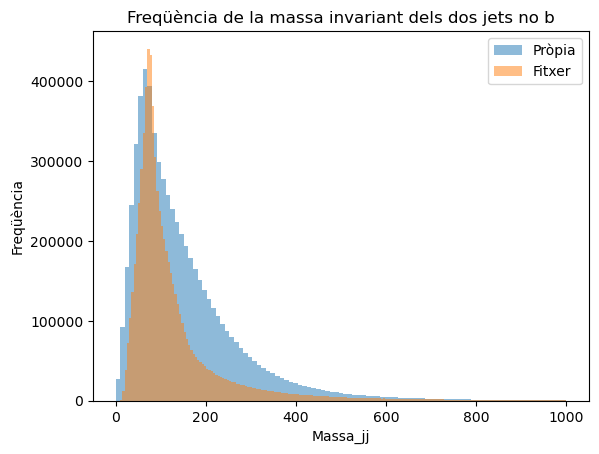

In [26]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 200)

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(nonorm.loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/MassaInvariant.png")
plt.show()

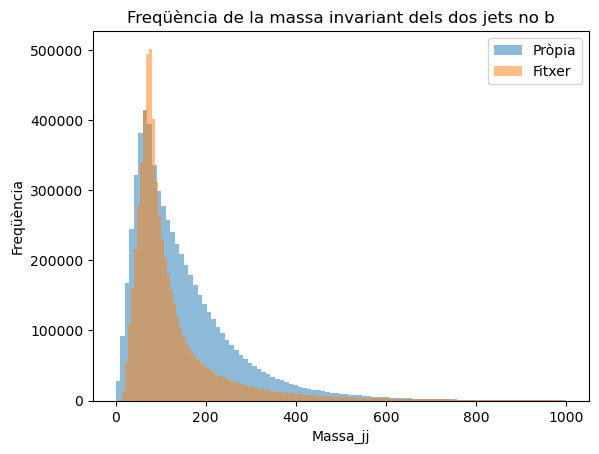

In [29]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 150)

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(someTr[someTr["btotal"] == 2].loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/mjjseleccio.png")
plt.show()

## Prova de nou únicament amb els events amb 4 jets

Provem a seleccionar únicament els events amb 4 jets. Cal que seleccionem els events i tb renomenem els eta com theta. Carreguem les dades primerament:

In [ ]:
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm1000.csv")
print(nonorm)

Ara seleccionem els esdeveniments amb 2btag i solament 4 jets i repetim la selecció de dades i el càlcul de theta (no eta).

In [30]:
someTr = nonorm[nonorm["btotal"] == 2]
someTr = someTr[someTr["njets"] == 4]
n_esdev = len(someTr)

vectors = pd.DataFrame(np.zeros([n_esdev,6]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2"]

for i in range(n_esdev):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan)) # Transforma eta en theta
vectors.columns = ["p1","theta1","phi1","p2","theta2","phi2"]
vectors.to_csv("jets4nob.csv", sep=',', index=False)

#  segons -->  minuts i  segons 

Calculem m_jj

In [32]:
m_jj = pd.DataFrame(np.zeros([len(vectors),0]))
m_jj = 1 - ( vectors.loc[:,"theta1"].apply(np.sin) * vectors.loc[:,"theta2"].apply(np.sin) * (vectors.loc[:,"phi1"] - vectors.loc[:,"phi2"]).apply(np.cos) )
m_jj = m_jj - ( vectors.loc[:,"theta1"].apply(np.cos) * vectors.loc[:,"theta2"].apply(np.cos) )
m_jj = np.sqrt( 2 * vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj )

Representem les dues distribucions

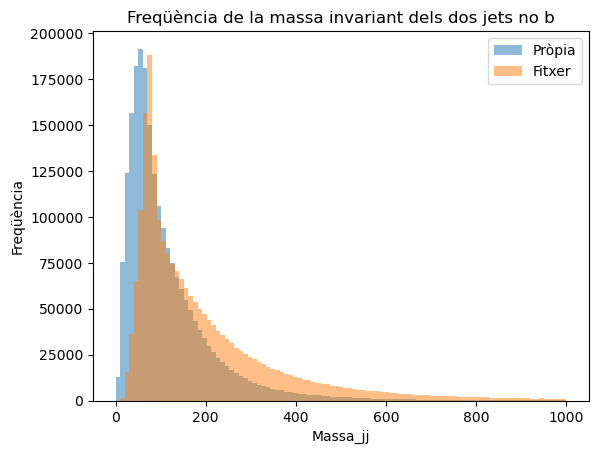

In [33]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 100)

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(someTr[someTr["btotal"] == 2].loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/prova.png")
plt.show()

## *2. Test trocejat --> mesuradors amb error*

Repetim càrrega de llibreries i dades

In [34]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# del(alltr,alltst)
# del(miltr, miltst)

# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
Audio(sound_file, autoplay=True)

Repetim el càlcul dels diferents mesuradors trocejant els tests. Primerament amb els DT.

!! Cal trencar en diferents tsts i calcular els diferents acc,kappa,F1S.

In [74]:
# batch = 500_000
# ntsts = int(len(Xtst)/batch)
# Xtsts = pd.DataFrame(np.zeros([batch,Xtst.shape[1],ntsts]))
# Ytsts = pd.DataFrame(np.zeros([batch,ntsts]))
# for i in range(ntsts):
#     Xtsts[i] = Xtst[batch*(i):batch*(i+1),:]
#     Ytsts[i] = Ytst[batch*(i):batch*(i+1)]

batch = 500_000
ntsts = int(len(Xtst)/batch)
acc,kappa,F1S = np.zeros(ntsts),np.zeros(ntsts),np.zeros(ntsts)

for i in range(ntsts):
    Xtst1, Ytst1 = Xtst[batch*i:batch*(i+1),:], Ytst[batch*i:batch*(i+1)]
    Ypred = clf.predict(Xtst1)
    acc[i] = clf.score(Xtst1, Ytst1)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst1)
    F1S[i] = metrics.f1_score(Ytst1,Ypred)

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))

print("| %s | %i |  %.4f ± %.4f |  %.4f ± %.4f |  %.4f ± %.4f | %i |" 
      % (label,max_depth,np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S),temps))


In [84]:
# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#        % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))



| d | 7 |  0.9077 ± 0.0004 |  0.8154 ± 0.0009 |  0.9099 ± 0.0004 | 54 |


Introduïm aquest nou mètode i recalculem:

In [88]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = alltr.iloc[:,0]
# Ytst = alltst.iloc[:,0]

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# j2) Alltr: 0 25 26 27
# Xdata = alltr.loc[:,["f0","f25","f26","mass"]]
# Xtst = alltst.loc[:,["f0","f25","f26","mass"]]
# label = "j2"


# Part 2: Càlcul DT
max_depth = 7

clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf = clf.fit(Xdata, Ydata)


# Part 3: Avaluació DT
# 3A: Partició del Xtst,Ytsts en diferents

batch = 5_000
ntsts = int(len(Xtst)/batch)
acc,kappa,F1S = np.zeros(ntsts),np.zeros(ntsts),np.zeros(ntsts)

for i in range(ntsts):
    Xtst1, Ytst1 = Xtst[batch*i:batch*(i+1),:], Ytst[batch*i:batch*(i+1)]
    Ypred = clf.predict(Xtst1)
    acc[i] = clf.score(Xtst1, Ytst1)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst1)
    F1S[i] = metrics.f1_score(Ytst1,Ypred)


temps = time.time() - startTime




# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))

print("| %s | %i |  %.4f ± %.4f |  %.4f ± %.4f |  %.4f ± %.4f | %i | %i |" 
      % (label,max_depth,np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S),ntsts,temps))


Audio(sound_file, autoplay=True)

| d | 7 |  0.9077 ± 0.0042 |  0.8154 ± 0.0085 |  0.9099 ± 0.0043 | 700 | 61 |


| labels | Max_depth |  Acc  | Kappa | F1-S | ntsts | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:----:|-------|
| *Proves amb miltr* |
| d | 7 |  0.9077 ± 0.0004 |  0.8154 ± 0.0009 |  0.9099 ± 0.0004 | 7 | 61 |
| d | 7 |  0.9077 ± 0.0014 |  0.8154 ± 0.0029 |  0.9099 ± 0.0015 | 70 | 58 |
| d | 7 |  0.9077 ± 0.0042 |  0.8154 ± 0.0085 |  0.9099 ± 0.0043 | 700 | 61 |


La mitjana és la mateixa (lògicament, perquè el nombre total de falsos/vertaders positius/negatius és el mateix) i únicament augmenta a mesura que partim en més ntsts. Sembla que no dóna cap resultat útil o raonable, caldria emprar altre mètode per calcular l'error. 
Possiblement podríem calcular els mesuradors amb diferents hiperparàmetres i després prendre la desviació? Però de nou sembla arbitrari escollir quins hiperparàmetres escollim i quins no per a la distribució. Es pot, diguem, "manufacturar" l'error que es vulga.